<a href="https://colab.research.google.com/github/Hiraeth19/Anomaly-Detection/blob/main/capstone_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import numpy as np
import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.svm import SVC

In [ ]:
def get_data(link):
  filenames = glob.glob(link)
  filenames.sort()
  images = [cv2.imread(img) for img in filenames]
  return images

In [ ]:
def get_all_images(base_dir, num_directories, type_data, extension='/*.tif'):
    all_images = []

    for i in range(1, num_directories + 1):
        directory_name = f"{base_dir}/{type_data}{str(i).zfill(3)}"
        filenames = glob.glob(directory_name + extension)
        filenames.sort()
        images = [cv2.imread(img) for img in filenames]
        all_images.extend(images)

    return all_images

base_directory = '/content/drive/MyDrive/ActivityRecogntiton'
num_directories = 200  # Change this to the number of directories you have

In [ ]:
# train_data = get_data("/content/drive/MyDrive/ActivityRecogntiton/Train001/*.tif")
train_data = get_all_images(base_directory,num_directories,"Train")

In [ ]:
len(train_data)

1000

In [ ]:
val_data = get_all_images(base_directory,2,"Test")

In [ ]:
# image_size = (64, 64)  # Resized image dimensions
# max_pixel_value = 255  # Maximum pixel value for normalization
# frames = []
# for img in images:

#   frame = cv2.resize(img, image_size)
#   # Convert frame to grayscale
#   frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
#   # Normalize pixel values to be between 0 and 1
#   frame = frame.astype(np.float32) / max_pixel_value

#   # Add frame to list of frames
#   frames.append(frame)
len(val_data)

410

In [ ]:

def preprocess_images(images, image_size=(64, 64), max_pixel_value=255):
    frames = []

    for img in images:
        frame = cv2.resize(img, image_size)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame = frame.astype(np.float32) / max_pixel_value
        frames.append(frame)

    return frames


In [ ]:
def preprocess_images_new(images, image_size=(64, 64), normalize=True):
    frames = []

    for img in images:
        # Resize while maintaining aspect ratio
        resized_frame = cv2.resize(img, image_size, interpolation=cv2.INTER_CUBIC)

        # Convert to grayscale
        gray_frame = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2GRAY)

        # # Normalize to mean 0 and standard deviation 1
        # if normalize:
        #     mean = np.mean(gray_frame)
        #     std = np.std(gray_frame)
        #     normalized_frame = (gray_frame - mean) / std
        #     frames.append(normalized_frame)
        # else:
        #     frames.append(gray_frame)
        frame = grey_frame.astype(np.float32) / max_pixel_value
        frames.append(frame)

    return frames

In [ ]:
train_frames = preprocess_images_new(train_data)
val_frames = preprocess_images_new(val_data)

In [ ]:
# #sliding window for subsequences


# window_size = 10  # Number of frames in each subsequence
# stride = 5  # Stride size for sliding the window

# # Prepare data for sliding window
# subsequences = []  # List to store subsequences

# # Apply sliding window
# # for sequence in frames:  # Iterate over original sequences
#     # seq_len = len(sequence)
# seq_len = len(frames)
# num_windows = (seq_len - window_size) // stride + 1  # Calculate number of windows

# # print(num_windows)
# for i in range(num_windows):
#     start = i * stride
#     end = start + window_size

#     subsequences.append(frames[start:end])
#     # cv2.imread(sequence,0)
#     # subsequences
#     # targets.append(target[start:end])

# # Convert lists to numpy arrays
# subsequences = np.array(subsequences)
# # targets = np.array(targets)

In [ ]:
def create_subsequences(frames, window_size=10, stride=5):
    subsequences = []

    # Apply sliding window on frames
    seq_len = len(frames)
    num_windows = (seq_len - window_size) // stride + 1

    for i in range(num_windows):
        start = i * stride
        end = start + window_size

        subsequences.append(frames[start:end])

    # Convert subsequences to a numpy array
    subsequences = np.array(subsequences)

    return subsequences

# train_data = create_subsequences(train_frames)
# val_data = create_subsequences(val_frames)


In [ ]:
def create_subsequences_new(frames, window_size=10, stride=5):
    subsequences_x = []  # Input subsequences
    subsequences_y = []  # Output subsequences (11th frame)

    seq_len = len(frames)
    num_windows = (seq_len - window_size - 1) // stride + 1

    for i in range(num_windows):
        start = i * stride
        end = start + window_size

        x_subseq = frames[start:end]  # Input sequence
        y_subseq = frames[end]  # 11th frame

        subsequences_x.append(x_subseq)
        subsequences_y.append(y_subseq)

    subsequences_x = np.array(subsequences_x)
    subsequences_y = np.array(subsequences_y)

    subsequences_y = subsequences_y.reshape(subsequences_y.shape[0], 1, subsequences_y.shape[1], subsequences_y.shape[2], 1)
    return subsequences_x, subsequences_y


In [ ]:

# Create subsequences for training data
X_train_subsequences, Y_train_subsequences = create_subsequences_new(train_frames)

# Create subsequences for validation data
X_val_subsequences, Y_val_subsequences = create_subsequences_new(val_frames)


In [ ]:
X_val_subsequences.shape
# X_val_subsequences, Y_val_subsequences = create_subsequences_new(val_frames)


(80, 10, 64, 64)

In [ ]:
# #encoder - decoder LSTM
# input_shape = (64, 64)
# encoder_units = 128

# output_shape = (1, 128)
# output_dim = (64, 64)  # Reconstruction
# decoder_units = 128

# # Define the encoder LSTM
# encoder_inputs = tf.keras.Input(shape=input_shape)
# encoder = tf.keras.layers.ConvLSTM2D(filters=32, kernel_size=(3, 3), )#encoder_units, return_state=True)
# _, state_h, state_c = encoder(encoder_inputs)
# encoder_states = [state_h, state_c]

# # Define the decoder LSTM
# decoder_inputs = tf.keras.Input(shape=output_shape)
# decoder_lstm = tf.keras.layers.ConvLSTM2D(decoder_units, return_sequences=True, return_state=False)
# decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)
# # decoder_dense = tf.keras.layers.Dense(output_dim, activation='sigmoid')
# decoder_outputs = decoder_dense(decoder_outputs)

# # Define the full model
# model = tf.keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

# # Compile the model
# model.compile(optimizer='adam', loss='binary_crossentropy')

# # Print the model summary
# model.summary()






In [ ]:
import tensorflow as tf
def ssim_loss(y_true, y_pred):
    return 1 - tf.image.ssim(y_true, y_pred, max_val=1.0)


# Encoder
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same', input_shape=(10, 64, 64, 1)))
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same'))

# Decoder
model.add(Conv3DTranspose(64, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model.add(Conv3DTranspose(32, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model.add(Conv3D(1, kernel_size=(3, 3, 3), activation='sigmoid', padding='same'))


(10, 64, 64, 1) --> (1, 64, 64, 1)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, Conv3DTranspose, AveragePooling3D

# Autoencoder Model
model = Sequential()

# Encoder
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same', input_shape=(10, 64, 64, 1))) # (10, 64, 64, 1) indicates 10 frames, 64 x 64 images, 1 channel (BW). (10, 64, 64, 1) --> (10, 64, 64, 32)
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same')) # (10, 64, 64, 32) --> (10, 64, 64, 64)
model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu', padding='same')) # (10, 64, 64, 64) --> (10, 64, 64, 128)


# Decoder
model.add(Conv3DTranspose(128, kernel_size=(3, 3, 3), activation='relu', padding='same')) # (10, 64, 64, 128) --> (10, 64, 64, 128)
model.add(Conv3DTranspose(64, kernel_size=(3, 3, 3), activation='relu', padding='same')) # (10, 64, 64, 128) --> (10, 64, 64, 64)
model.add(Conv3DTranspose(32, kernel_size=(3, 3, 3), activation='relu', padding='same')) # (10, 64, 64, 64) --> (10, 64, 64, 32)
model.add(Conv3D(1, kernel_size=(3, 3, 3), activation='sigmoid', padding='same')) # (10, 64, 64, 32) --> (10, 64, 64, 1)
model.add(AveragePooling3D(pool_size=(10, 1, 1))) # (10, 64, 64, 1) --> (1, 64, 64, 1) CONVERTS DEPTH 10 TO DEPTH 1 -- now use loss to make this equal to 11th frame

# Print Model Summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 10, 64, 64, 32)    896       
                                                                 
 conv3d_1 (Conv3D)           (None, 10, 64, 64, 64)    55360     
                                                                 
 conv3d_2 (Conv3D)           (None, 10, 64, 64, 128)   221312    
                                                                 
 conv3d_transpose (Conv3DTra  (None, 10, 64, 64, 128)  442496    
 nspose)                                                         
                                                                 
 conv3d_transpose_1 (Conv3DT  (None, 10, 64, 64, 64)   221248    
 ranspose)                                                       
                                                                 
 conv3d_transpose_2 (Conv3DT  (None, 10, 64, 64, 32)   5

In [ ]:
# Compile the model
# model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError())
# model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanAbsoluteError())
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=ssim_loss)


In [ ]:
# Train the model
# model.fit(X_train_subsequences, Y_train_subsequences, epochs=15, batch_size=32)
model.fit(
    X_train_subsequences, Y_train_subsequences,
    epochs=15, batch_size=32,
    validation_data=(X_val_subsequences, Y_val_subsequences)
)


Epoch 1/15
7/7 [==============================] - 15s 2s/step - loss: 0.3092 - val_loss: 0.1779
Epoch 2/15
7/7 [==============================] - 11s 2s/step - loss: 0.1826 - val_loss: 0.1411
Epoch 3/15
7/7 [==============================] - 11s 2s/step - loss: 0.1503 - val_loss: 0.1143
Epoch 4/15
7/7 [==============================] - 11s 2s/step - loss: 0.1229 - val_loss: 0.0977
Epoch 5/15
7/7 [==============================] - 12s 2s/step - loss: 0.1042 - val_loss: 0.0862
Epoch 6/15
7/7 [==============================] - 12s 2s/step - loss: 0.0898 - val_loss: 0.0729
Epoch 7/15
7/7 [==============================] - 11s 2s/step - loss: 0.0767 - val_loss: 0.0696
Epoch 8/15
7/7 [==============================] - 11s 2s/step - loss: 0.0688 - val_loss: 0.0544
Epoch 9/15
7/7 [==============================] - 11s 2s/step - loss: 0.0581 - val_loss: 0.0456
Epoch 10/15
7/7 [==============================] - 11s 2s/step - loss: 0.0524 - val_loss: 0.0424
Epoch 11/15
7/7 [======================

1/1 [==============================] - 0s 443ms/step


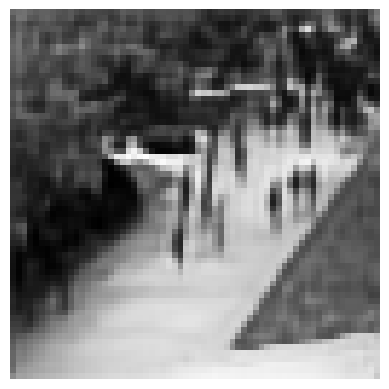

In [ ]:
import matplotlib.pyplot as plt
sequence = X_val_subsequences[0]
reshaped_sequence = sequence.reshape(1, 10, 64, 64, 1)
reconstructed_data = model.predict(reshaped_sequence)

# Assuming you have a single predicted frame
predicted_frame = reconstructed_data[0, ...]  # Assuming shape (64, 64, 1)

# Remove the channel dimension if it exists
predicted_frame = predicted_frame.squeeze()

# Display the predicted frame as an image
plt.imshow(predicted_frame, cmap='gray')
plt.axis('off')
plt.show()

# error = mae

In [ ]:
from tensorflow.keras.models import save_model
save_model(model, '/content/drive/MyDrive/model2.h5')


1/1 [==============================] - 0s 162ms/step


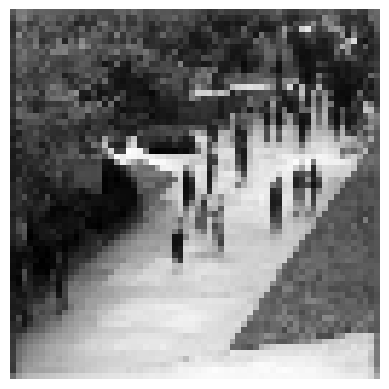

In [ ]:
import matplotlib.pyplot as plt
sequence = X_val_subsequences[0]
reshaped_sequence = sequence.reshape(1, 10, 64, 64, 1)
reconstructed_data = model.predict(reshaped_sequence)

# Assuming you have a single predicted frame
predicted_frame = reconstructed_data[0, ...]  # Assuming shape (64, 64, 1)

# Remove the channel dimension if it exists
predicted_frame = predicted_frame.squeeze()

# Display the predicted frame as an image
plt.imshow(predicted_frame, cmap='gray')
plt.axis('off')
plt.show()

#error = ssim

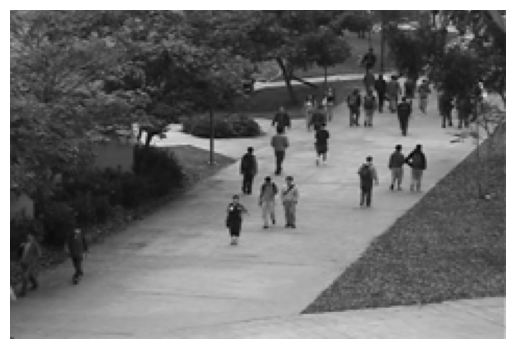

In [ ]:
image = cv2.imread('/content/drive/MyDrive/ActivityRecogntiton/Test001/011.tif')

# Display the predicted frame as an image
plt.imshow(image , cmap='gray')
plt.axis('off')
plt.show()


In [ ]:
image.shape

(158, 238, 3)

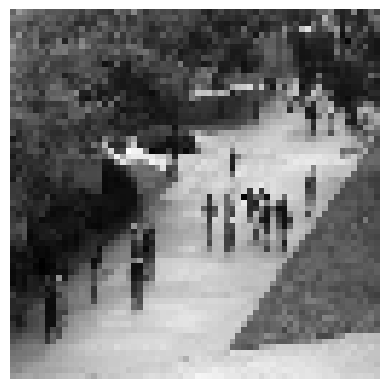

In [ ]:

# Display the predicted frame as an image
image = Y_train_subsequences[0]
image_reshaped = image.squeeze()
plt.imshow(image_reshaped , cmap='gray')
plt.axis('off')
plt.show()


In [ ]:
custom_objects = {'ssim_loss': ssim_loss}

# Load the saved model with the custom loss function
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/model2.h5', custom_objects=custom_objects)
# loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/model2.h5')


In [ ]:
loaded_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_10 (Conv3D)          (None, 10, 64, 64, 32)    896       
                                                                 
 conv3d_11 (Conv3D)          (None, 10, 64, 64, 64)    55360     
                                                                 
 conv3d_12 (Conv3D)          (None, 10, 64, 64, 128)   221312    
                                                                 
 conv3d_transpose_7 (Conv3DT  (None, 10, 64, 64, 128)  442496    
 ranspose)                                                       
                                                                 
 conv3d_transpose_8 (Conv3DT  (None, 10, 64, 64, 64)   221248    
 ranspose)                                                       
                                                                 
 conv3d_transpose_9 (Conv3DT  (None, 10, 64, 64, 32)  

In [ ]:
# def find_anomolous(start_frame,end_frame,frames):
#     # Define the anomalous frame ranges for each video
#   anomalous_frames_video1 = range(start_frame, end_frame)  # 60 to 152 inclusive
#   # anomalous_frames_video2 = range(50, 176)  # 50 to 175 inclusive

#   # Initialize a list to store subsequences with anomalous 11th frame
#   subsequences_with_anomalous_11th = []
#   subsequence_number = 1
#   # Loop through subsequences
#   for start_frame_index in range(0, len(frames) - 10 + 1, 5):  # Adjust video_frames accordingly
#       # Check for anomalous 11th frame for both videos
#       if (start_frame_index + 10) in anomalous_frames_video1 :

#           subsequences_with_anomalous_11th.append(subsequence_number)
#       subsequence_number += 1
#   # print("Subsequences with anomalous 11th frame:", subsequences_with_anomalous_11th)
#   return subsequences_with_anomalous_11th
# def find_anomolous(start_frame, end_frame, frames):
#     # Define the anomalous frame ranges
#     anomalous_frames = range(start_frame, end_frame + 1)  # Define your anomalous frame range

#     # Initialize lists to store subsequences with anomalous and normal 11th frames
#     anomalous_subsequences = []
#     normal_subsequences = []
#     subsequence_number = 0

#     # Loop through subsequences
#     for start_frame_index in range(0, len(frames) - 10 + 1, 5):
#         # Check if the 11th frame is anomalous
#         if (start_frame_index + 10) in anomalous_frames:
#             anomalous_subsequences.append(subsequence_number)
#         else:
#             normal_subsequences.append(subsequence_number)

#         subsequence_number += 1

#     return anomalous_subsequences, normal_subsequences
def find_anomolous(start_frame, end_frame, frames, window_size=10, stride=5):
    # Define the anomalous frame ranges
    anomalous_frames = range(start_frame, end_frame + 1)  # Define your anomalous frame range

    # Initialize lists to store subsequences with anomalous and normal 11th frames
    anomalous_subsequences = []
    normal_subsequences = []
    subsequence_number = 0

    # Loop through subsequences
    num_windows = (len(frames) - window_size + 1) // stride
    for i in range(num_windows):
        start_frame_index = i * stride
        end_frame_index = start_frame_index + window_size - 1

        # Check if the 11th frame is anomalous
        if end_frame_index + 1 in anomalous_frames:
            anomalous_subsequences.append(subsequence_number)
        else:
            normal_subsequences.append(subsequence_number)

        subsequence_number += 1

    return anomalous_subsequences, normal_subsequences

In [ ]:
def cal_ssim_values(X_subsequences,Y_subsequences):
  model = loaded_model
  ssim_values = []
  model.compile(optimizer='adam', loss=ssim_loss)
  for index in range(len(X_subsequences)):
    X_frames = X_subsequences[index].reshape(1, 10, 64, 64)
    Y_pred = model.predict(X_frames)
    ssim_values = ssim_loss(Y_subsequences,Y_pred)
  return ssim_values


In [ ]:
## for visualizing the error
def visiualize_error(anomalous_subsequences,ssim_values):
  subsequence_numbers = list(range(1, len(ssim_values) + 1))

  # Plot the SSIM values over subsequence numbers
  plt.figure(figsize=(10, 6))
  plt.scatter(subsequence_numbers, ssim_values, color='blue', label='SSIM Value')
  plt.scatter(anomalous_subsequences, [ssim_values[i - 1] for i in anomalous_subsequences], color='red', label='Anomalous Subsequences')
  plt.xlabel('Subsequence Number')
  plt.ylabel('SSIM Value')
  plt.title('SSIM Values and Anomalous Subsequences')
  plt.legend()
  plt.show()
  return ssim_values


In [ ]:
def plot_error(link,start_frame,end_frame):
  frames = get_data(link)
  frames = preprocess_images(frames)
  X_subsequences, Y_subsequences = create_subsequences_new(frames)

  anomalous_subsequences,normal_subsequences = find_anomolous(start_frame,end_frame,frames)
  ssim_values = cal_ssim_values(X_subsequences,Y_subsequences)
  visiualize_error(anomalous_subsequences,ssim_values)


1/1 [==============================] - 0s 18ms/step


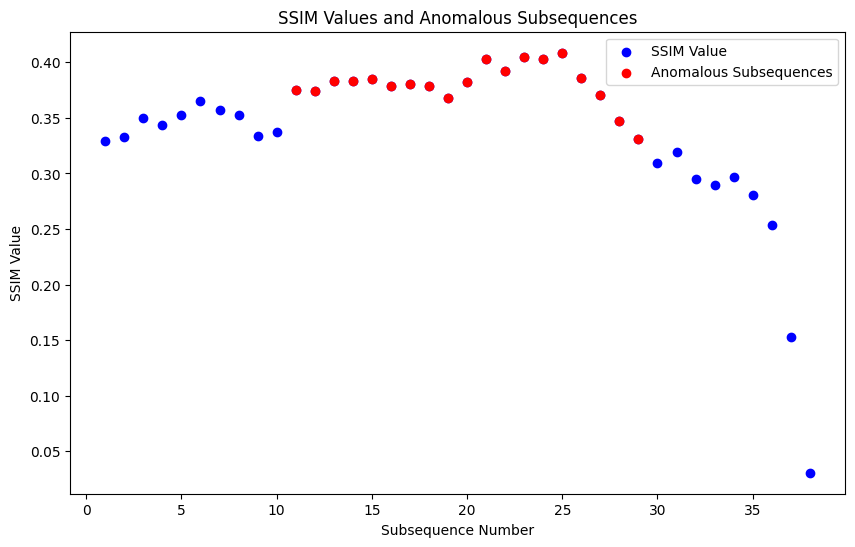

In [ ]:
plot_error("/content/drive/MyDrive/ActivityRecogntiton/Test001/*.tif",60,152)

1/1 [==============================] - 0s 19ms/step


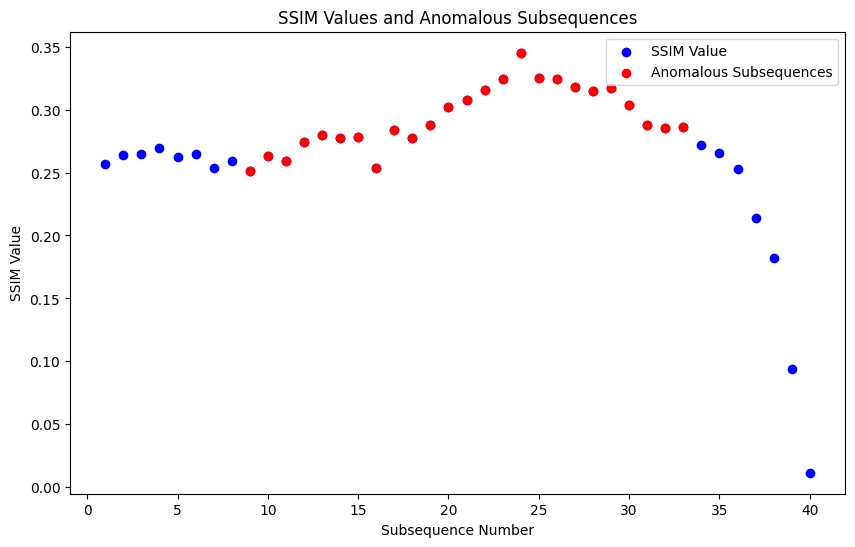

In [ ]:
plot_error("/content/drive/MyDrive/ActivityRecogntiton/Test002/*.tif",50,175)


In [ ]:
from sklearn.model_selection import train_test_split
def find_error_threshold(link,start_frame,end_frame):
# link = "/content/drive/MyDrive/ActivityRecogntiton/Test002/*.tif"
# start_frame = 50
# end_frame = 175
  frames = get_data(link)
  frames = preprocess_images(frames)
  X_subsequences, Y_subsequences = create_subsequences_new(frames)

  anomalous_subsequences,normal_subsequences = find_anomolous(start_frame,end_frame,frames)
  ssim_values =  cal_ssim_values(X_subsequences,Y_subsequences)
  ssim_values_np = ssim_values.numpy()
  y_normal= [ssim_values_np[index][0] for index in normal_subsequences]
  y_anomalous = [ssim_values_np[index][0] for index in anomalous_subsequences]
  x_normal = np.array(normal_subsequences)
  x_anomalous = np.array(anomalous_subsequences)

  normal_data = np.column_stack((x_normal, y_normal))
  anomalous_data = np.column_stack((x_anomalous, y_anomalous))

  # Combine the normal and anomalous data
  combined_data = np.vstack((normal_data, anomalous_data))
  # Create labels for the normal and anomalous classes (0 for normal, 1 for anomalous)
  labels = np.concatenate((np.zeros(len(normal_data)), np.ones(len(anomalous_data))))

  X_train, X_test, y_train, y_test = train_test_split(combined_data, labels, test_size=0.2, random_state=42)
  # Initialize and train the SVM model
  # svm_model = SVC(probability = True)
  # svm_model.fit(X_train, y_train)
  # Initialize and train the SVM model
  svm_model = SVC(kernel='poly')
  svm_model.fit(X_train, y_train)





1/1 [==============================] - 0s 18ms/step


SVC(kernel='poly')

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
# # Fit the model on the training data
# model = LogisticRegression()

# model.fit(X_train, y_train)

# Predict on the testing data
y_pred = svm_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.88


In [ ]:
# probs = svm_model.predict_proba(X_test)[:, 1]
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# # Vary threshold and choose based on metrics
# best_threshold = 0
# best_metric = 0

# for threshold in np.linspace(0, 1, 100):
#     y_pred = (probs >= threshold).astype(int)
#     accuracy = accuracy_score(y_test, y_pred)
#     precision = precision_score(y_test, y_pred)
#     recall = recall_score(y_test, y_pred)
#     f1 = f1_score(y_test, y_pred)

#     # Choose threshold based on desired metric (e.g., F1-score)
#     metric = accuracy  # You can use accuracy, precision, recall, or any other metric

#     if metric > best_metric:
#         best_metric = metric
#         best_threshold = threshold

# print("Best Threshold:", best_threshold)





coef = model.coef_
intercept = model.intercept_

In [ ]:
find_error_threshold("/content/drive/MyDrive/ActivityRecogntiton/Test002/*.tif",50,175)

[0.25684416, 0.26366466, 0.2649392, 0.2696067, 0.26264054, 0.2647341, 0.25399983, 0.25888252, 0.2651922, 0.25257212, 0.213633, 0.18229753, 0.093520105, 0.011457205]
